# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=55c03bcb8bdf4fd1b8b2ea39b34383ba6d1c8865ad82b5864f273730ba42d155
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=2dd3a4d697cd27eb5136e918ea10e665f6dee86dba68533dac35478641b76ea6
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

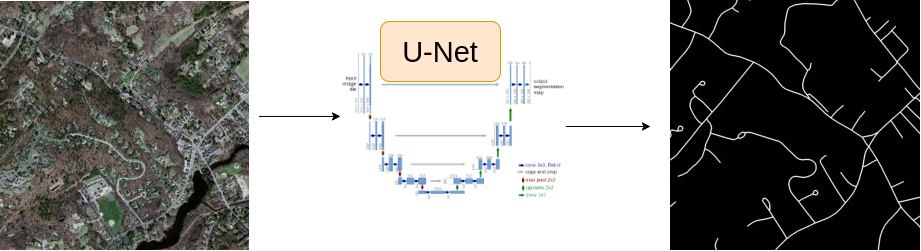

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 17.08 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [25]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'
DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
idx = 15
row = df.iloc[idx]
image_path =DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

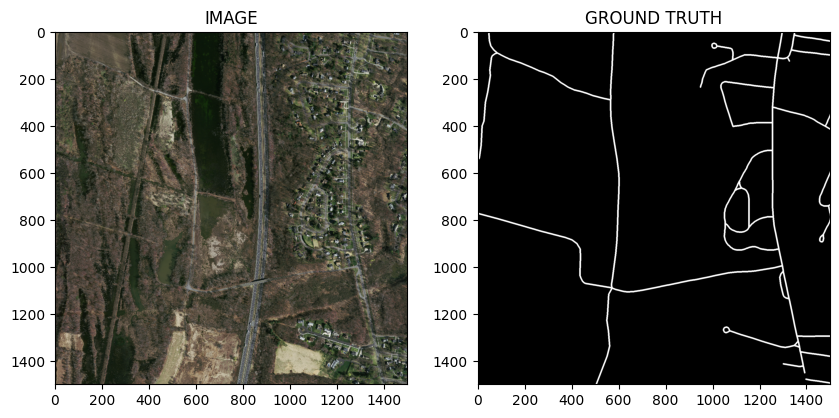

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(512, 512),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])


def get_valid_augs():
  return A.Compose([
      A.Resize(512, 512)
  ])

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path =DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)
    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image'] #(h,w,c)
      mask = data['mask']
    image = np.transpose(image,(2,0,1)).astype(float) #(c,h,w)
    mask = np.transpose(mask,(2,0,1)).astype(float)

    image = torch.Tensor(image)/255
    mask = torch.round(torch.Tensor(mask)/255)

    return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f'Length of Trainset : {len(trainset)}')
print(f'Length of Validset : {len(validset)}')

Length of Trainset : 159
Length of Validset : 40


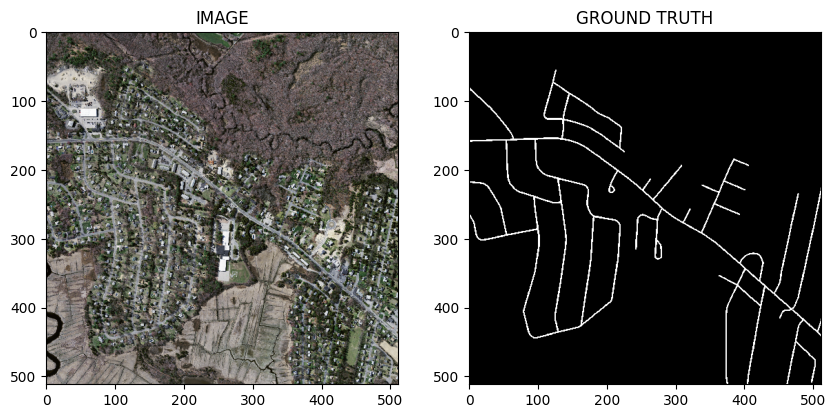

In [16]:
idx = 21
image,mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f'Length of Trainloader : {len(trainloader)}')
print(f'Length of Trainloader : {len(validloader)}')

Length of Trainloader : 20
Length of Trainloader : 5


In [21]:
for images, mask in trainloader:
  print(f"Shape of images : {images.shape}")
  print(f"Shape of masks : {mask.shape}")
  break

Shape of images : torch.Size([8, 3, 512, 512])
Shape of masks : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn

In [36]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.backbone(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [41]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function

In [38]:
def train_fn(dataloader, model, optimizer):
  model.train()
  total_train_loss = 0
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()
  return total_train_loss/len(dataloader)

In [39]:
def eval_fn(dataloader, model, optimizer):
  model.eval()
  total_train_loss = 0
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_train_loss += loss.item()
  return total_train_loss/len(dataloader)

# Task 8 : Train Model

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [42]:
best_loss = np.inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model, optimizer)
  if valid_loss < best_loss:
    best_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_loss = valid_loss
  print(f"Epoch : {i+1}")
  print(f"Train Loss : {train_loss}")
  print(f"Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


SAVED MODEL
Epoch : 1
Train Loss : 1.5249797642230987
Valid Loss : 1.4879773616790772


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch : 2
Train Loss : 1.5247429132461547
Valid Loss : 1.4943692922592162


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch : 3
Train Loss : 1.5254549860954285
Valid Loss : 1.5095379114151002


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


SAVED MODEL
Epoch : 4
Train Loss : 1.526428872346878
Valid Loss : 1.4875729084014893


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch : 5
Train Loss : 1.525262212753296
Valid Loss : 1.5065695762634277


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch : 6
Train Loss : 1.5252845585346222
Valid Loss : 1.5050066471099854


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch : 7
Train Loss : 1.5253682255744934
Valid Loss : 1.5053189516067504


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch : 8
Train Loss : 1.5244432389736176
Valid Loss : 1.4967782974243165


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch : 9
Train Loss : 1.5239678621292114
Valid Loss : 1.4975289106369019


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch : 10
Train Loss : 1.5245479822158814
Valid Loss : 1.4998851060867309


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Epoch : 11
Train Loss : 1.524703574180603
Valid Loss : 1.5031195163726807


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch : 12
Train Loss : 1.5254436552524566
Valid Loss : 1.4981539249420166


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch : 13
Train Loss : 1.5242730498313903
Valid Loss : 1.5102537631988526


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch : 14
Train Loss : 1.5245885789394378
Valid Loss : 1.5104438304901122


100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Epoch : 15
Train Loss : 1.5231601119041442
Valid Loss : 1.5098979473114014


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch : 16
Train Loss : 1.5256968498229981
Valid Loss : 1.5021769046783446


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Epoch : 17
Train Loss : 1.5251008987426757
Valid Loss : 1.5016479730606078


100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


Epoch : 18
Train Loss : 1.5261145114898682
Valid Loss : 1.5099380016326904


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch : 19
Train Loss : 1.5239035487174988
Valid Loss : 1.508633542060852


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Epoch : 20
Train Loss : 1.524917906522751
Valid Loss : 1.503490972518921


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch : 21
Train Loss : 1.5267940700054168
Valid Loss : 1.510832166671753


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch : 22
Train Loss : 1.523884403705597
Valid Loss : 1.5054289817810058


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Epoch : 23
Train Loss : 1.5237097144126892
Valid Loss : 1.501943588256836


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch : 24
Train Loss : 1.5248059928417206
Valid Loss : 1.5110343933105468


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]

Epoch : 25
Train Loss : 1.5244146823883056
Valid Loss : 1.50987708568573


# Task 9 : Inference

In [43]:
idx = 17

In [44]:
model.load_state_dict(torch.load('best_model.pt'))
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1

<ipython-input-44-076e74c5ceb0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


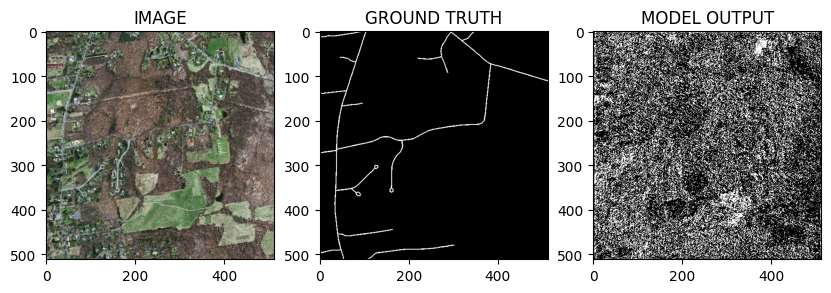

In [45]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

